In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline


In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/luohy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load the data

In [3]:
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
print(dataset.shape)
print(dataset.head(10))
print(dataset.describe())

(24783, 3)
   label                                              tweet  \
0      2  !!! rt @mayasolovely: as a woman you shouldn't...   
1      1  !!!!! rt @mleew17: boy dats cold...tyga dwn ba...   
2      1  !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...   
3      1  !!!!!!!!! rt @c_g_anderson: @viva_based she lo...   
4      1  !!!!!!!!!!!!! rt @shenikaroberts: the shit you...   
5      1  !!!!!!!!!!!!!!!!!!"@t_madison_x: the shit just...   
6      1  !!!!!!"@__brighterdays: i can not just sit up ...   
7      1  !!!!“@selfiequeenbri: cause i'm tired of you b...   
8      1  " & you might not get ya bitch back & thats th...   
9      1  " @rhythmixx_ :hobbies include: fighting maria...   

       label_category  
0             Neutral  
1  Offensive Language  
2  Offensive Language  
3  Offensive Language  
4  Offensive Language  
5  Offensive Language  
6  Offensive Language  
7  Offensive Language  
8  Offensive Language  
9  Offensive Language  
              label
count  2478

labels:

- hate 0
- offensive 1
- netural 2
  

In [4]:
from sklearn.model_selection import train_test_split

X = dataset['tweet']  # Input features
y = dataset['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape: ", X_train.shape, "\nLabel distribution: \n", y_train.value_counts())
print("\nTesting set shape: ", X_test.shape, "\nLabel distribution: \n", y_test.value_counts())

Training set shape:  (19826,) 
Label distribution: 
 label
1    15358
2     3328
0     1140
Name: count, dtype: int64

Testing set shape:  (4957,) 
Label distribution: 
 label
1    3832
2     835
0     290
Name: count, dtype: int64


### Feature engineering and imbalanced data handling

The goal is to choose the best method to deal with imbalanced dataset

- resampling method: SMOTE, ENN, SMOTEENN
- tokenizer: tweet
- vectorizer: tf-idf 
- ml models: logistic regression, random forest

Resampling Methods:
- Oversampling: SMOTE
- Undersampling: ENN
- Typically, SMOTEENN and other combined resampling strategies would be used to increase the number of instances in underrepresented classes, not to decrease the instances in the majority class.

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

[nltk_data] Downloading package stopwords to /Users/luohy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.base import SamplerMixin

class CustomSMOTE(BaseEstimator, ClassifierMixin):
    def __init__(self, sampling_strategy='auto', k_neighbors=5, random_state=42):
        self.sampler = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)

    def fit_resample(self, X, y):
        X_res, y_res = self.sampler.fit_resample(X, y)
        self.sampled_y_ = y_res
        return X_res, y_res
    
class CustomENN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=3, kind_sel='all'):
        self.sampler = EditedNearestNeighbours(n_neighbors=n_neighbors, kind_sel=kind_sel)

    def fit_resample(self, X, y):
        X_res, y_res = self.sampler.fit_resample(X, y)
        self.sampled_y_ = y_res
        return X_res, y_res

class CustomSMOTEENN(BaseEstimator, ClassifierMixin):
    def __init__(self, smote_params=None, enn_params=None, sampling_strategy=None, random_state=None):
        # Initialize SMOTE and ENN with any provided parameters
        self.smote = SMOTE(**(smote_params if smote_params else {}))
        self.enn = EditedNearestNeighbours(**(enn_params if enn_params else {}))
        # Initialize SMOTEENN with the appropriate sampling_strategy
        self.sampler = SMOTEENN(smote=self.smote, enn=self.enn, sampling_strategy=sampling_strategy,
                                random_state=random_state, n_jobs=-1)

    def fit_resample(self, X, y):
        X_res, y_res = self.sampler.fit_resample(X, y)
        self.sampled_y_ = y_res
        return X_res, y_res


### Fine tuning resampling methods

In [55]:
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt", "MENTIONHERE","HTTPURL"]
stopwords.extend(other_exclusions)

# Define sampling methods

smote_params = {
    'sampling_strategy' : {0: 8000, 2: 8000},
    'k_neighbors': 5
}
enn_params = {
    'n_neighbors': 3,  # More neighbors for a less aggressive cleaning
    'kind_sel': 'mode'
}

# sampling_strategy={0: 2000, 2: 4000}
sampling_strategy = {0: 8000, 2: 8000}

sampling_methods = {
    'CustomSMOTE': CustomSMOTE(k_neighbors=5, random_state=42),
    'CustomENN': CustomENN(n_neighbors=5, kind_sel='all'),
    'CustomSMOTEENN': CustomSMOTEENN(sampling_strategy=sampling_strategy, 
                                     smote_params=smote_params,
                                     enn_params=enn_params,
                                     random_state=42)
}

# Define vectorizers
# Update the vectorizers
vectorizers = {
    'TfidfVectorizer_Tweet': TfidfVectorizer(
        tokenizer=TweetTokenizer().tokenize,
        ngram_range=(1, 3),
        stop_words=stopwords,
        use_idf=True,
        smooth_idf=False,
        norm=None,
        decode_error='replace',
        max_features=10000,
        min_df=5,
        max_df=0.75
        ),
    # 'TfidfVectorizer_Word': TfidfVectorizer(
    #     tokenizer=word_tokenize,
    #     ngram_range=(1, 3),
    #     stop_words=stopwords,
    #     use_idf=True,
    #     smooth_idf=False,
    #     norm=None,
    #     decode_error='replace',
    #     max_features=10000,
    #     min_df=5,
    #     max_df=0.75
    #     )
}

# Define models
models = {
    'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Construct pipelines for each combination of sampling methods, vectorizers, and models
pipelines = []
for sampling_method_name, sampling_method in sampling_methods.items():
    for vectorizer_name, vectorizer in vectorizers.items():
        for model_name, model in models.items():
            steps = [('vectorizer', vectorizer),
                     ('sampling', sampling_method),
                     ('clf', model)]
            pipeline_name = f"{sampling_method_name}_{vectorizer_name}_{model_name}"
            pipeline = ImbPipeline(steps)
            pipelines.append((pipeline_name, sampling_method_name, model_name, pipeline))


## Model Training & Evaluation

Metrics chosen:
- TP: is hate, predict hate
- TN: is offensive, predict offensive
- FP: is offensive, predict hate
- FN: is hate, predict offensive  -- we want to avoid this

To minimize false negatives, you would typically optimize for high recall and consider the F1 Score to ensure that the increase in recall doesn't compromise precision too much. 
- Recall (Sensitivity): This is the primary metric you should focus on if you want to minimize false negatives.  Recall = TP / TP + FN
- F1 Score: While recall is focused on minimizing false negatives, it does not take into account the number of false positives (incorrectly labeling negative cases as positive). The F1 Score provides a balance between recall and precision (which measures the accuracy of the positive predictions made by the model)
- Accuray: will be viewd as a side measurement.

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score

res = []

# Train and evaluate each pipeline
for pipeline_name, sampling_method_name, model_name, pipeline in pipelines:
    print(f"Training {pipeline_name}...")
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # print the distribution of labels in the training set before resampling
    print(f"Training label distribution before resampling: {np.bincount(y_train)}")

    # Print the distribution of labels in the training set after resampling
    sampled_y = pipeline.named_steps['sampling'].sampled_y_
    print(f"Training label distribution after resampling: {np.bincount(sampled_y)}")
    
    # Evaluate the pipeline on the testing data
    y_pred = pipeline.predict(X_test)

    accuracy_general = accuracy_score(y_test, y_pred)
    recall_class0 = recall_class_0 = recall_score(y_test, y_pred, labels=[0], average=None)[0]
    f1_class_0 = f1_score(y_test, y_pred, labels=[0], average=None)[0]  

    res.append({
        'Pipeline': pipeline_name, 
        'Sampling Method': sampling_method_name,
        'Model': model_name,
        'Recall_hate': recall_class_0, 
        'F1_hate': f1_class_0, 
        'Accuracy_general': accuracy_general})
    
    # Print classification report
    print(f"Evaluation results for {pipeline_name}:")
    print(classification_report(y_test, y_pred, target_names=['Hate Speech', 'Offensive Language', 'Neutral'])) 


    # # Draw Confusion matrix
    # # Evaluate models by the confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    
    # # Extract FP, FN from confusion matrix
    # tn, fp, fn, tp = cm.ravel()
    
    # # Calculate false positives (FP) and false negatives (FN)
    # false_positives = fp / (fp + tn)
    # false_negatives = fn / (fn + tp)

    # # Create a confusion matrix plot
    # fig, ax = plt.subplots()

    # # Plot the confusion matrix
    # for (j, i), label in np.ndenumerate(cm):
    #     ax.text(i, j, label, ha='center', va='center')

    # ax.set_title(f'{pipeline_name}\nConfusion Matrix\n\nAccuracy: {accuracy:.2f}\nFalse Positives: {false_positives:.2f} / False Negatives: {false_negatives:.2f}')
    # ax.imshow(cm, cmap='tab20c')
    # ax.set_xticks([1, 0])
    # ax.set_yticks([1, 0])
    # ax.set_xlabel('Predict')
    # ax.set_ylabel('True')
    

Training CustomSMOTE_TfidfVectorizer_Tweet_LogisticRegression...


/Users/luohy/Documents/Projects/ML4health/projenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/luohy/Documents/Projects/ML4health/projenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['httpurl', 'mentionhere'] not in stop_words.
  warnings.warn(


Training label distribution before resampling: [ 1140 15358  3328]
Training label distribution after resampling: [15358 15358 15358]
Evaluation results for CustomSMOTE_TfidfVectorizer_Tweet_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.21      0.34      0.26       290
Offensive Language       0.92      0.87      0.89      3832
           Neutral       0.79      0.78      0.78       835

          accuracy                           0.83      4957
         macro avg       0.64      0.66      0.65      4957
      weighted avg       0.85      0.83      0.84      4957

Training CustomSMOTE_TfidfVectorizer_Tweet_RandomForest...


/Users/luohy/Documents/Projects/ML4health/projenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training label distribution before resampling: [ 1140 15358  3328]
Training label distribution after resampling: [15358 15358 15358]
Evaluation results for CustomSMOTE_TfidfVectorizer_Tweet_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.42      0.23      0.30       290
Offensive Language       0.91      0.95      0.93      3832
           Neutral       0.79      0.75      0.77       835

          accuracy                           0.87      4957
         macro avg       0.71      0.64      0.66      4957
      weighted avg       0.86      0.87      0.86      4957

Training CustomENN_TfidfVectorizer_Tweet_LogisticRegression...


/Users/luohy/Documents/Projects/ML4health/projenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training label distribution before resampling: [ 1140 15358  3328]
Training label distribution after resampling: [1140 8456  481]
Evaluation results for CustomENN_TfidfVectorizer_Tweet_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.20      0.67      0.31       290
Offensive Language       0.91      0.85      0.88      3832
           Neutral       0.84      0.43      0.57       835

          accuracy                           0.77      4957
         macro avg       0.65      0.65      0.59      4957
      weighted avg       0.86      0.77      0.79      4957

Training CustomENN_TfidfVectorizer_Tweet_RandomForest...


/Users/luohy/Documents/Projects/ML4health/projenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training label distribution before resampling: [ 1140 15358  3328]
Training label distribution after resampling: [1140 8456  481]
Evaluation results for CustomENN_TfidfVectorizer_Tweet_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.24      0.60      0.35       290
Offensive Language       0.91      0.88      0.90      3832
           Neutral       0.76      0.51      0.61       835

          accuracy                           0.80      4957
         macro avg       0.64      0.66      0.62      4957
      weighted avg       0.85      0.80      0.82      4957

Training CustomSMOTEENN_TfidfVectorizer_Tweet_LogisticRegression...


/Users/luohy/Documents/Projects/ML4health/projenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training label distribution before resampling: [ 1140 15358  3328]
Training label distribution after resampling: [8000 9881 7368]
Evaluation results for CustomSMOTEENN_TfidfVectorizer_Tweet_LogisticRegression:
                    precision    recall  f1-score   support

       Hate Speech       0.22      0.55      0.31       290
Offensive Language       0.95      0.82      0.88      3832
           Neutral       0.75      0.86      0.80       835

          accuracy                           0.81      4957
         macro avg       0.64      0.74      0.66      4957
      weighted avg       0.88      0.81      0.83      4957

Training CustomSMOTEENN_TfidfVectorizer_Tweet_RandomForest...


/Users/luohy/Documents/Projects/ML4health/projenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training label distribution before resampling: [ 1140 15358  3328]
Training label distribution after resampling: [8000 9954 7374]
Evaluation results for CustomSMOTEENN_TfidfVectorizer_Tweet_RandomForest:
                    precision    recall  f1-score   support

       Hate Speech       0.37      0.38      0.38       290
Offensive Language       0.94      0.91      0.92      3832
           Neutral       0.75      0.85      0.79       835

          accuracy                           0.87      4957
         macro avg       0.69      0.71      0.70      4957
      weighted avg       0.87      0.87      0.87      4957



# Result Visualization

In [57]:
df_res = pd.DataFrame(res)

df_LR = df_res[df_res['Model'] == 'LogisticRegression']
df_RF = df_res[df_res['Model'] == 'RandomForest']

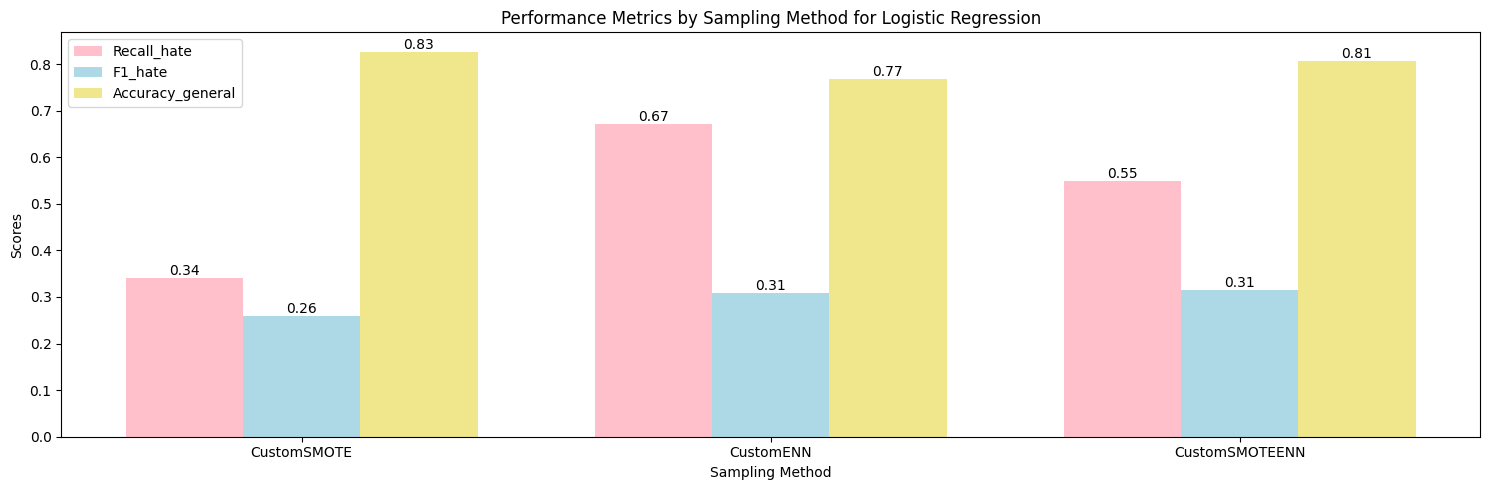

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df_LR' has columns 'Sampling Method', 'Recall', 'F1', and 'Accuracy'
# which correspond to the sampling method and the performance metrics.

# Parameters
n_methods = len(df_LR['Sampling Method'].unique())
n_metrics = 3  # Number of metrics (Recall, F1, Accuracy)
bar_width = 0.2  # width of the bars
index = np.arange(n_methods)  # array of positions for each sampling method

# Spacing between the groups of bars for each metric
group_width = bar_width * n_metrics

# Starting positions for each metric's bars
positions = {
    'Recall_hate': index * (group_width + bar_width),  # Recall starts at 0, 3.2, 6.4, ...
    'F1_hate': (index * (group_width + bar_width)) + bar_width,  # F1 is offset by the width of one bar
    'Accuracy_general': (index * (group_width + bar_width)) + 2 * bar_width  # Accuracy is offset by two bar widths
}

fig, ax = plt.subplots(figsize=(15, 5))

# Colors for the bars
colors = ['pink', 'lightblue', 'khaki']  # Prettier and clearer colors

# Create bars for each metric and annotate each bar with its value
for (metric, pos), color in zip(positions.items(), colors):
    bars = ax.bar(pos, df_LR[metric], bar_width, label=f'{metric}', color=color)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Sampling Method')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Sampling Method for Logistic Regression')
ax.set_xticks(positions['Recall_hate'] + bar_width)  # Centers the tick marks between bars
ax.set_xticklabels(df_LR['Sampling Method'])
ax.legend()

# Improve layout and display
plt.tight_layout()
plt.show()

# save the image to img folder
fig.savefig('./img/Performance Metrics by Sampling Method for Logistic Regression.png')


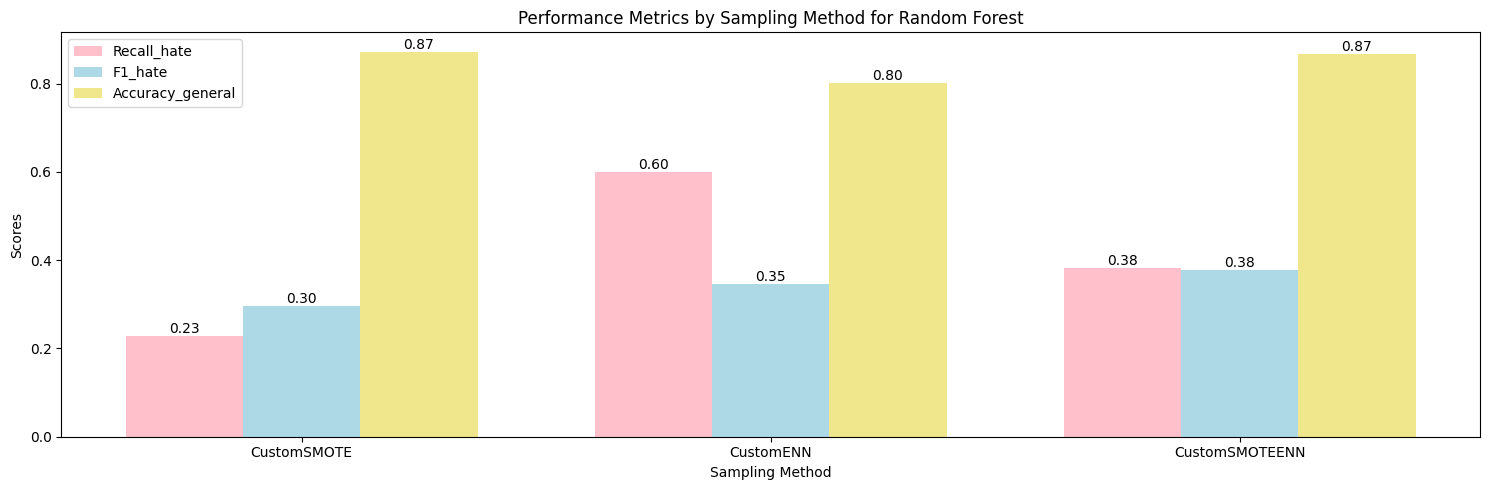

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df_LR' has columns 'Sampling Method', 'Recall', 'F1', and 'Accuracy'
# which correspond to the sampling method and the performance metrics.

# Parameters
n_methods = len(df_RF['Sampling Method'].unique())
n_metrics = 3  # Number of metrics (Recall, F1, Accuracy)
bar_width = 0.2  # width of the bars
index = np.arange(n_methods)  # array of positions for each sampling method

# Spacing between the groups of bars for each metric
group_width = bar_width * n_metrics

# Starting positions for each metric's bars
positions = {
    'Recall_hate': index * (group_width + bar_width),  # Recall starts at 0, 3.2, 6.4, ...
    'F1_hate': (index * (group_width + bar_width)) + bar_width,  # F1 is offset by the width of one bar
    'Accuracy_general': (index * (group_width + bar_width)) + 2 * bar_width  # Accuracy is offset by two bar widths
}

fig, ax = plt.subplots(figsize=(15, 5))

# Colors for the bars
colors = ['pink', 'lightblue', 'khaki']  # Prettier and clearer colors

# Create bars for each metric and annotate each bar with its value
for (metric, pos), color in zip(positions.items(), colors):
    bars = ax.bar(pos, df_RF[metric], bar_width, label=f'{metric}', color=color)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')


# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Sampling Method')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Sampling Method for Random Forest')
ax.set_xticks(positions['Recall_hate'] + bar_width)  # Centers the tick marks between bars
ax.set_xticklabels(df_RF['Sampling Method'])
ax.legend()

# Improve layout and display
plt.tight_layout()
plt.show()

# save the image to img folder
fig.savefig('./img/Performance Metrics by Sampling Method for Random Forest.png')
